# Goodman's Correction for Mean Offset

In [1]:
import Pkg
Pkg.activate("/Users/cmichel/repos/owens")
using OWENS: safeakima, rainflow
using Plots


This program is running OWENS.jl, the Offshore/Onshore Wind/Water Energy Simulator

Copyright 2013-2024
National Technology & Engineering Solutions of Sandia, LLC (NTESS). 
Under the terms of Contract DE-NA0003525 with NTESS, 
the U.S. Government retains certain rights in this software.

Licensed under the LGPL GNU LESSER GENERAL PUBLIC LICENSE V3.0 License;
you may not use this file except in compliance with the License.

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.



  Activating project at `~/repos/owens`


In [2]:
function fatigue_damage(stress, sn_stress, sn_log_cycles, ultimate_strength; nbins_amplitude=20, nbins_mean=1, mean_correction=true, wohler_exp=3, equiv_cycles=1)
    ncycles, mean_bins, amplitude_bins, _ = rainflow(stress; nbins_range=nbins_amplitude, nbins_mean, m=wohler_exp, Teq=equiv_cycles)
    amplitude_levels = (amplitude_bins[1:end-1] .+ amplitude_bins[2:end]) ./ 2 # bin centers
    mean_levels = (mean_bins[1:end-1] .+ mean_bins[2:end]) ./ 2 # bin centers
    if mean_correction
        ncycles = [(ncycles...)] # flatten matrix
        effective_amplitude_levels = [iamplitude / (1 - imean / ultimate_strength) for iamplitude in amplitude_levels, imean in mean_levels]
        effective_amplitude_levels = [(effective_amplitude_levels...)] # flatten matrix
    else
        ncycles = sum(ncycles, dims=2) # sum over mean bins
        effective_amplitude_levels = amplitude_levels
    end
    log_ncycles_fail = safeakima(sn_stress, sn_log_cycles, effective_amplitude_levels) # interpolation
    ncycles_fail = 10.0 .^ log_ncycles_fail
    return sum(ncycles ./ ncycles_fail)
end

fatigue_damage (generic function with 1 method)

## Stress time series

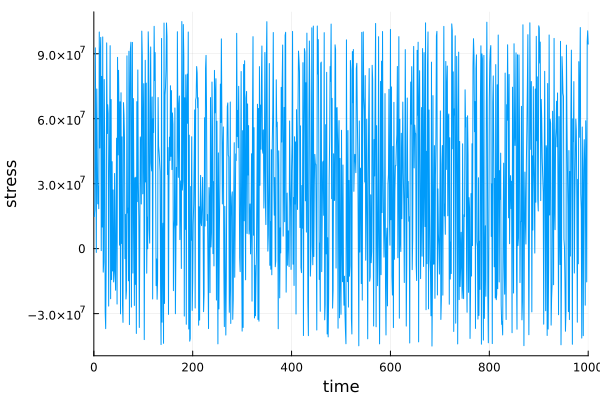

In [3]:
amplitude, mean = 150e6, 30e6
stress = (rand(1000) .- 0.5)*amplitude .+ mean
plot(stress; xlabel="time", ylabel="stress", label=nothing, xlim=(0,Inf))

## Material properties

In [4]:
ultimate_strength = 500e6
failure_strength_coefficient = 250e6
fatigue_exponent = -0.12
ncycles = 1:1000:(1e5+1)
sn_log_cycles = log10.(ncycles)
sn_stress = failure_strength_coefficient * ncycles.^fatigue_exponent

ncycles = vcat(ncycles, 1e7)
sn_log_cycles = vcat(sn_log_cycles, log10(1e7))
sn_stress = vcat(sn_stress, 1e5);

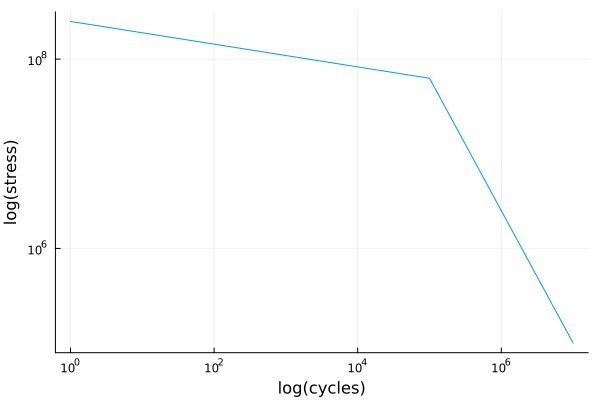

In [5]:
plot(ncycles, sn_stress; xscale=:log10, yscale=:log10, xlabel="log(cycles)", ylabel="log(stress)", label=nothing)

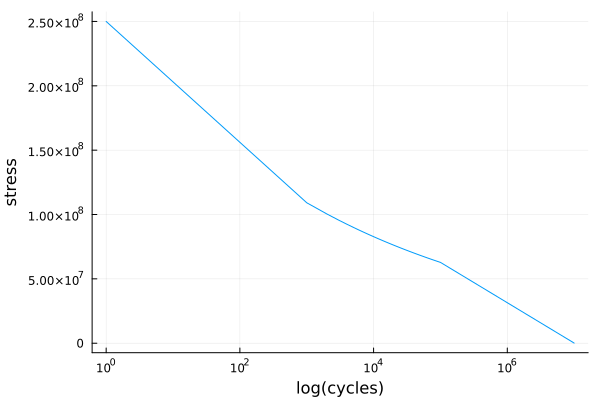

In [6]:
plot(ncycles, sn_stress; xscale=:log10, xlabel="log(cycles)", ylabel="stress", label=nothing)

## Fatigue damage

In [7]:
fatigue_damage(stress, sn_stress, sn_log_cycles, ultimate_strength; nbins_amplitude=20, nbins_mean=20, mean_correction=true, wohler_exp=3, equiv_cycles=1)

1.4803260328181322e9